# Мобильные приложения - Выделение групп пользователей на основе поведения

**Описание проекта**

Наши пользователи сервиса «Ненужные вещи» совершают много действий в приложении, и мы уверены, что в этих данных есть инсайты, которые позволят нам стать лучшим приложением для продажи ненужных вещей.

«Ненужные вещи» — ваши ненужные вещи нужны кому-то другому!

**Описание данных**

Датасет содержит данные о событиях, совершенных в мобильном приложении "Ненужные вещи". В нем пользователи продают свои ненужные вещи, размещая их на доске объявлений.

В датасете содержатся данные пользователей, впервые совершивших действия в приложении после 7 октября 2019 года.

Колонки в `/datasets/mobile_sources.csv`:
- `userId` — идентификатор пользователя,
- `source` — источник, с которого пользователь установил приложение.

Колонки в `/datasets/mobile_dataset.csv`:
- `event.time` — время совершения,
- `user.id` — идентификатор пользователя,
- `event.name` — действие пользователя.

Виды действий:
- `adverts_open` — открыл карточки объявлений,
- `photos_show` — просмотрел фотографий в объявлении,
- `tips_show` — увидел рекомендации объявлений,
- `tips_click` — кликнул по рекомендованному объявлению,
- `contacts_show` и `show_contacts` — просмотрел номер телефона,
- `contacts_call` — позвонил по номеру из объявления,
- `map` — открыл карту объявлений,
- `search_1` — `search_7` — разные действия, связанные с поиском по сайту,
- `favorites_add` — добавил объявление в избранное.

**План работы**

1. Выгрузка данных и библиотек
2. Предобработка данных
- 2.1 Проверка и корректировка названий столбцов 
- 2.2 Проверка и корректировка типов данных
- 2.3 Обьеденение таблиц, событий и добавление столбцов
- 2.4 Исследуем выбросы
3. Анализ поведения пользователей
- 3.1 Retention rate
- 3.2 Время, проведённое в приложении
- 3.3 Частота действий
- 3.4 Конверсия в целевое действие — просмотр контактов
4. Сегментируем пользователей на основе действий
5. Проверка гипотез
- 5.1 Некоторые пользователи установили приложение по ссылке из yandex , другие — из google . Проверим гипотезу: две эти группы демонстрируют разную конверсию в просмотры контактов.
- 5.2 Время, проведенное в приложении, отличается в зависимости от источника установки приложения (google, yandex)
6. Основные выводы

## Выгрузка данных и библиотек

In [1]:
#Импорт библиотек
import pandas as pd
import datetime as dt
import numpy as np
import math as mth
import scipy.stats as stats
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
import calendar
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import plotly.graph_objs as go

from datetime import datetime, timedelta
from matplotlib import rcParams
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.preprocessing import StandardScaler
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.cluster import KMeans
from scipy import stats as st
pd.set_option('display.max_colwidth', 150)
pd.options.display.float_format = '{:,.2f}'.format
plt.style.use('dark_background')
sns.set_style("dark")
warnings.filterwarnings('ignore')

In [2]:
#Загрузим и посмотрим данные
data = pd.read_csv('/datasets/mobile_dataset.csv', sep=',')
sources = pd.read_csv('/datasets/mobile_sources.csv', sep=',')

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74197 entries, 0 to 74196
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   event.time  74197 non-null  object
 1   event.name  74197 non-null  object
 2   user.id     74197 non-null  object
dtypes: object(3)
memory usage: 1.7+ MB


In [4]:
data.head(10)

,event.time,event.name,user.id
0,2019-10-07 00:00:00.431357,advert_open,020292ab-89bc-4156-9acf-68bc2783f894
1,2019-10-07 00:00:01.236320,tips_show,020292ab-89bc-4156-9acf-68bc2783f894
2,2019-10-07 00:00:02.245341,tips_show,cf7eda61-9349-469f-ac27-e5b6f5ec475c
3,2019-10-07 00:00:07.039334,tips_show,020292ab-89bc-4156-9acf-68bc2783f894
4,2019-10-07 00:00:56.319813,advert_open,cf7eda61-9349-469f-ac27-e5b6f5ec475c
5,2019-10-07 00:01:19.993624,tips_show,cf7eda61-9349-469f-ac27-e5b6f5ec475c
6,2019-10-07 00:01:27.770232,advert_open,020292ab-89bc-4156-9acf-68bc2783f894
7,2019-10-07 00:01:34.804591,tips_show,020292ab-89bc-4156-9acf-68bc2783f894
8,2019-10-07 00:01:49.732803,advert_open,cf7eda61-9349-469f-ac27-e5b6f5ec475c
9,2019-10-07 00:01:54.958298,advert_open,020292ab-89bc-4156-9acf-68bc2783f894


В датасете **dataset** 3 поля и 74197 строк, судя по info пропущенных значений полей нет. В полях содержится следующая информация:

1. **event.time** - время совершения события, формат object
2. **event.name** - название события, формат object
3. **user.id** - идентификатор пользователя, формат object

In [5]:
sources.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4293 entries, 0 to 4292
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   userId  4293 non-null   object
 1   source  4293 non-null   object
dtypes: object(2)
memory usage: 67.2+ KB


In [6]:
sources.head(10)

,userId,source
0,020292ab-89bc-4156-9acf-68bc2783f894,other
1,cf7eda61-9349-469f-ac27-e5b6f5ec475c,yandex
2,8c356c42-3ba9-4cb6-80b8-3f868d0192c3,yandex
3,d9b06b47-0f36-419b-bbb0-3533e582a6cb,other
4,f32e1e2a-3027-4693-b793-b7b3ff274439,google
5,17f6b2db-2964-4d11-89d8-7e38d2cb4750,yandex
6,62aa104f-592d-4ccb-8226-2ba0e719ded5,yandex
7,57321726-5d66-4d51-84f4-c797c35dcf2b,google
8,c2cf55c0-95f7-4269-896c-931d14deaab5,google
9,48e614d6-fe03-40f7-bf9e-4c4f61c19f64,yandex


В датасете **sources** 2 поля и 4293  строк, судя по info пропущенных значений полей нет. В полях содержится следующая информация:
1. **userId** - идентификатор пользователя, формат object
2. **source** - источник, с которого пользователь установил приложение, формат object

В датасетах уже заметны некоторые проблемы: неправильный формат даты, названия полей, неприведенные к силю snake_case. Разберемся с ними в предобработке

## Предобработка данных

### Проверка и корректировка названий столбцов

Изменим названия столбцов data

In [7]:
data.columns = ['event_time', 'event_name', 'user_id']

In [8]:
data.head()

,event_time,event_name,user_id
0,2019-10-07 00:00:00.431357,advert_open,020292ab-89bc-4156-9acf-68bc2783f894
1,2019-10-07 00:00:01.236320,tips_show,020292ab-89bc-4156-9acf-68bc2783f894
2,2019-10-07 00:00:02.245341,tips_show,cf7eda61-9349-469f-ac27-e5b6f5ec475c
3,2019-10-07 00:00:07.039334,tips_show,020292ab-89bc-4156-9acf-68bc2783f894
4,2019-10-07 00:00:56.319813,advert_open,cf7eda61-9349-469f-ac27-e5b6f5ec475c


Изменим названия столбцов sources

In [9]:
sources.columns = ['user_id', 'source']

In [10]:
sources.head()

,user_id,source
0,020292ab-89bc-4156-9acf-68bc2783f894,other
1,cf7eda61-9349-469f-ac27-e5b6f5ec475c,yandex
2,8c356c42-3ba9-4cb6-80b8-3f868d0192c3,yandex
3,d9b06b47-0f36-419b-bbb0-3533e582a6cb,other
4,f32e1e2a-3027-4693-b793-b7b3ff274439,google


### Проверка и корректировка типов данных

Приведем столбец event_time датасета data к формату даты и округлим данные до 1 секунды

In [11]:
data['event_time'] = pd.to_datetime(data['event_time'], format='%Y.%m.%d %H:%M:%S').dt.round('1S')

In [12]:
data.head()

,event_time,event_name,user_id
0,2019-10-07 00:00:00,advert_open,020292ab-89bc-4156-9acf-68bc2783f894
1,2019-10-07 00:00:01,tips_show,020292ab-89bc-4156-9acf-68bc2783f894
2,2019-10-07 00:00:02,tips_show,cf7eda61-9349-469f-ac27-e5b6f5ec475c
3,2019-10-07 00:00:07,tips_show,020292ab-89bc-4156-9acf-68bc2783f894
4,2019-10-07 00:00:56,advert_open,cf7eda61-9349-469f-ac27-e5b6f5ec475c


### Обьеденение таблиц, событий и добавление столбцов

Проверим количество пользователей в data

In [13]:
len(data['user_id'].unique())

4293

Проверим количество пользователей в sources

In [14]:
len(sources['user_id'].unique())

4293

In [15]:
set(sources['user_id']) == set(data['user_id'])

True

Количество пользователей в обоих датасетах совпадает, можно склеить их в один.

In [16]:
df = data.merge(sources, on='user_id', how = 'right')

In [17]:
df.sample(5)

,event_time,event_name,user_id,source
34226,2019-10-18 12:09:27,tips_show,cd3ba0cc-dfbc-4067-bcd7-c29e4649796e,yandex
15964,2019-10-11 00:55:37,photos_show,68560c33-d2d7-4c4f-b903-3c76b1180d07,yandex
23307,2019-10-19 17:16:10,advert_open,04adf25e-cb60-4cbd-bedc-ddc1057cde06,other
12987,2019-10-11 15:54:43,tips_show,bc4d25a1-69ab-41a4-b1d1-0aa9a8848563,yandex
44063,2019-10-20 13:49:36,map,7d451fd2-3c9a-4fe9-8e44-0013fb331e7d,google


Выделим из столбцов с датами час, неделю, месяц, год и полную дату в отдельные столбцы

In [18]:
df['event_hour'] = df['event_time'].dt.hour
df['event_week'] = df['event_time'].astype('datetime64[W]')
df['event_month'] = df['event_time'].astype('datetime64[M]')
df['event_year'] = df['event_time'].astype('datetime64[Y]')
df['event_date'] = df['event_time'].astype('datetime64[D]')

In [19]:
df.sample(10)

,event_time,event_name,user_id,source,event_hour,event_week,event_month,event_year,event_date
50921,2019-10-31 09:46:39,favorites_add,b76914c3-031d-43f6-95e7-aec7750a0bee,other,9,2019-10-31,2019-10-01,2019-01-01,2019-10-31
51848,2019-10-30 14:17:27,tips_show,774e7c61-f52d-47f7-bf9f-ce2e94860a08,other,14,2019-10-24,2019-10-01,2019-01-01,2019-10-30
37153,2019-10-17 20:42:24,tips_show,a5b2560d-e6ab-4dc8-b67b-cfaa01785150,yandex,20,2019-10-17,2019-10-01,2019-01-01,2019-10-17
56179,2019-10-25 11:03:00,advert_open,899d586a-b53e-4389-aeff-0b0b8464d7be,yandex,11,2019-10-24,2019-10-01,2019-01-01,2019-10-25
64479,2019-10-28 17:29:15,favorites_add,25c2b646-5bb0-4000-a841-b62a8bd2654b,other,17,2019-10-24,2019-10-01,2019-01-01,2019-10-28
51933,2019-10-23 14:35:57,tips_show,9fff2d56-7556-4079-91c9-65eada6904b8,google,14,2019-10-17,2019-10-01,2019-01-01,2019-10-23
29819,2019-10-15 14:30:39,tips_show,2a10f5e5-e207-467f-8c08-c4c9a6091e30,yandex,14,2019-10-10,2019-10-01,2019-01-01,2019-10-15
30286,2019-10-15 16:23:04,contacts_show,5b4b2187-100b-43f3-8307-aed30dcbd690,yandex,16,2019-10-10,2019-10-01,2019-01-01,2019-10-15
42353,2019-10-19 18:14:15,tips_show,a23b735a-7812-4284-868b-f63904eff7bb,other,18,2019-10-17,2019-10-01,2019-01-01,2019-10-19
28752,2019-10-15 07:45:52,search_1,6d9ae54c-dd4d-4f4e-9d54-db1b622556ed,yandex,7,2019-10-10,2019-10-01,2019-01-01,2019-10-15


Посмотрим, что в столбцах event_name и source

In [20]:
df['source'].value_counts()

yandex    34286
google    20445
other     19466
Name: source, dtype: int64

In [21]:
df['event_name'].value_counts()

tips_show        40055
photos_show      10012
advert_open       6164
contacts_show     4450
map               3881
search_1          3506
favorites_add     1417
search_5          1049
tips_click         814
search_4           701
contacts_call      541
search_3           522
search_6           460
search_2           324
search_7           222
show_contacts       79
Name: event_name, dtype: int64

Так как события contacts_show и show_contacts обозначают одно и то же событие - пользователь нажал на кнопку "Показать номер телефона", то можно склеить их в одно. Аналогично можно поступить с событиями search, т.к в нашем исследовании неважно, что именно ищут пользователи.

In [22]:
def events_type(i):
    if i == 'show_contacts':
        new_name = 'contacts_show'
        return new_name
    elif 'search' in i:
        new_name = 'search'
        return new_name
    return i

df['event_name'] = df['event_name'].apply(events_type)

In [23]:
df['event_name'].value_counts()

tips_show        40055
photos_show      10012
search            6784
advert_open       6164
contacts_show     4529
map               3881
favorites_add     1417
tips_click         814
contacts_call      541
Name: event_name, dtype: int64

In [24]:
df.tail()

,event_time,event_name,user_id,source,event_hour,event_week,event_month,event_year,event_date
74192,2019-11-03 23:46:47,map,d157bffc-264d-4464-8220-1cc0c42f43a9,google,23,2019-10-31,2019-11-01,2019-01-01,2019-11-03
74193,2019-11-03 23:46:59,advert_open,d157bffc-264d-4464-8220-1cc0c42f43a9,google,23,2019-10-31,2019-11-01,2019-01-01,2019-11-03
74194,2019-11-03 23:47:01,tips_show,d157bffc-264d-4464-8220-1cc0c42f43a9,google,23,2019-10-31,2019-11-01,2019-01-01,2019-11-03
74195,2019-11-03 23:47:47,advert_open,d157bffc-264d-4464-8220-1cc0c42f43a9,google,23,2019-10-31,2019-11-01,2019-01-01,2019-11-03
74196,2019-11-03 23:47:50,tips_show,d157bffc-264d-4464-8220-1cc0c42f43a9,google,23,2019-10-31,2019-11-01,2019-01-01,2019-11-03


Посмотрим, за какой период у нас есть данные

In [25]:
display(f'В логе представлены события за период с {df["event_date"].min().date()} по {df["event_date"].max().date()}')
display(f'Выборка в днях составляет {df["event_time"].max()-df["event_time"].min()}')

'В логе представлены события за период с 2019-10-07 по 2019-11-03'

'Выборка в днях составляет 27 days 23:58:13'

Так как в выборке представленны данные за 28 дней будем строить понедельные когорты

### Исследуем выбросы

Посмотрим количество действий на пользователя, что бы устранить "гиперактивных"

In [26]:
user_events = df.pivot_table(index='user_id', aggfunc={'event_name':'count'})
user_events.columns = ['event_count']
display('Минимум событий на одного пользователя:', user_events['event_count'].min())
display('Максимум событий на одного пользователя:', user_events['event_count'].max())

'Минимум событий на одного пользователя:'

1

'Максимум событий на одного пользователя:'

478

In [27]:
user_events.describe()

,event_count
count,"4,293.00"
mean,17.28
std,29.13
min,1.00
25%,5.00
50%,9.00
75%,17.00
max,478.00


Посмотрим какое влияние оказывает tips_show - это автоматическое действие и ни как не зависит от действий пользователей

In [28]:
dff = df.query('event_name != "tips_show"')

In [29]:
dff['user_id'].nunique(), df['user_id'].nunique()

(3586, 4293)

In [30]:
user_events_clean = dff.pivot_table(index='user_id', aggfunc={'event_name':'count'})
user_events_clean.columns = ['event_count']
display('Минимум событий на одного пользователя:', user_events_clean['event_count'].min())
display('Максимум событий на одного пользователя:', user_events_clean['event_count'].max())

'Минимум событий на одного пользователя:'

1

'Максимум событий на одного пользователя:'

336

In [31]:
user_events_clean.describe()

,event_count
count,"3,586.00"
mean,9.52
std,16.32
min,1.00
25%,3.00
50%,5.00
75%,10.00
max,336.00


Если удалим будут большие потери. Оставим как есть

## Анализ поведения пользователей

### Retention Rate

Разобьем пользователей на когорты на основе даты их первой активности в приложении.

In [32]:
first_date = df.groupby(['user_id'])['event_date'].min()
first_date.name = 'start_dt'
df = df.join(first_date,on='user_id')

In [33]:
df.sample(10)

,event_time,event_name,user_id,source,event_hour,event_week,event_month,event_year,event_date,start_dt
5513,2019-10-07 23:37:58,tips_show,bf615847-1fad-4267-a97e-3406ba6b5600,google,23,2019-10-03,2019-10-01,2019-01-01,2019-10-07,2019-10-07
68653,2019-10-30 21:46:19,tips_show,0a552292-3c41-4210-b265-ee45445ebb51,yandex,21,2019-10-24,2019-10-01,2019-01-01,2019-10-30,2019-10-30
67703,2019-10-30 14:13:50,search,ba5fbe23-71a2-4de5-b355-041c8775e1a4,other,14,2019-10-24,2019-10-01,2019-01-01,2019-10-30,2019-10-30
49582,2019-10-22 16:22:37,tips_show,10c16025-f8e5-47bd-89db-db679a030fdb,yandex,16,2019-10-17,2019-10-01,2019-01-01,2019-10-22,2019-10-22
16026,2019-10-11 18:50:27,tips_show,689677d5-7d3f-47af-9a27-56e88bbebce7,google,18,2019-10-10,2019-10-01,2019-01-01,2019-10-11,2019-10-11
67197,2019-10-30 11:51:46,contacts_show,9a8f5b68-87a6-4468-93e1-2130d5de0e63,other,11,2019-10-24,2019-10-01,2019-01-01,2019-10-30,2019-10-30
34582,2019-10-16 22:15:12,tips_show,abb304e9-f0c7-4ab8-9914-51a092a81ec5,yandex,22,2019-10-10,2019-10-01,2019-01-01,2019-10-16,2019-10-16
7158,2019-10-15 15:45:19,search,07eff6a2-4b3c-4f16-8fa0-87b5731d3ab2,yandex,15,2019-10-10,2019-10-01,2019-01-01,2019-10-15,2019-10-08
9250,2019-10-08 23:49:58,photos_show,689d45cc-5bed-41ce-bf20-5801b9de6d8d,google,23,2019-10-03,2019-10-01,2019-01-01,2019-10-08,2019-10-08
59523,2019-11-03 19:20:53,tips_show,114101ba-29e8-4f20-98ae-80434d6e918a,yandex,19,2019-10-31,2019-11-01,2019-01-01,2019-11-03,2019-10-26


Найдем когорту

In [34]:
df['activ_week'] = pd.to_datetime(df['event_date'],
                                                unit='d') - pd.to_timedelta(df['event_date'].dt.dayofweek, unit='d')
df['start_week'] = pd.to_datetime(df['start_dt'],
                                                      unit='d') - pd.to_timedelta(df['start_dt'].dt.dayofweek, unit='d')

In [35]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 74197 entries, 0 to 74196
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   event_time   74197 non-null  datetime64[ns]
 1   event_name   74197 non-null  object        
 2   user_id      74197 non-null  object        
 3   source       74197 non-null  object        
 4   event_hour   74197 non-null  int64         
 5   event_week   74197 non-null  datetime64[ns]
 6   event_month  74197 non-null  datetime64[ns]
 7   event_year   74197 non-null  datetime64[ns]
 8   event_date   74197 non-null  datetime64[ns]
 9   start_dt     74197 non-null  datetime64[ns]
 10  activ_week   74197 non-null  datetime64[ns]
 11  start_week   74197 non-null  datetime64[ns]
dtypes: datetime64[ns](8), int64(1), object(3)
memory usage: 7.4+ MB


Расcчитаем lifetime

In [36]:
df['cohort_lifetime'] = df['activ_week'] - df['start_week']
df['cohort_lifetime'] = df['cohort_lifetime'] / np.timedelta64(1,'W')
df['cohort_lifetime'] = df['cohort_lifetime'].astype(int)

Сгруппируем данные по когорте и lifetime.

In [37]:
cohorts = df.groupby(['start_week','cohort_lifetime']).agg({'user_id':'nunique'}).reset_index()

Найдём количество пользователей в когорте. Возьмём их число на нулевую неделю:

In [38]:
initial_users_count = cohorts[cohorts['cohort_lifetime'] == 0][['start_week','user_id']]

In [39]:
initial_users_count = initial_users_count.rename(columns={'user_id':'cohort_users'})
cohorts = cohorts.merge(initial_users_count,on='start_week')

Посчитаем Retention Rate. Разделим количество активных пользователей в каждую из недель на исходное число пользователей в когорте

In [40]:
cohorts['retention'] = cohorts['user_id']/cohorts['cohort_users']

In [41]:
cohorts['start_week'] = cohorts['start_week'].dt.date

In [42]:
retention_pivot = cohorts.pivot_table(index='start_week',columns='cohort_lifetime',values='retention',aggfunc='sum')

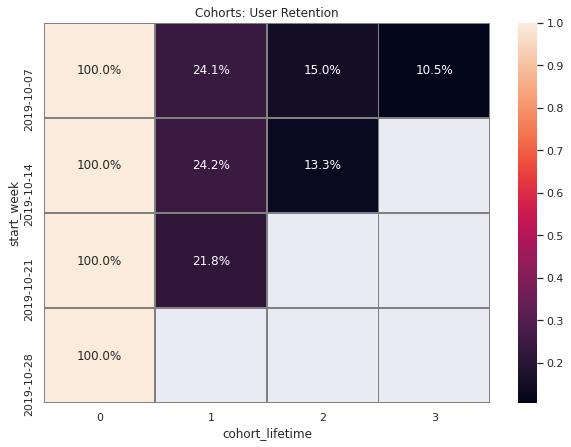

In [43]:
sns.set(style='dark')
plt.figure(figsize=(10, 7))
plt.title('Cohorts: User Retention')
sns.heatmap(retention_pivot, annot=True, fmt='.1%', linewidths=1, linecolor='gray');

Анализ когорт показал закономерное снижение Retention Rate со временем:

Удержание пользователей значительно падает уже на второй неделе после установки приложения. Например, для когорты от 7 до 13 октября доля вернувшихся пользователей на второй неделе составляет лишь 7%, а для более поздних когорт — ещё меньше.

Новые когорты демонстрируют всё более низкий уровень удержания, что может свидетельствовать о снижении интереса к приложению, ухудшении первого опыта или недостаточной ценности для пользователей.

Такая динамика указывает на то, что основная часть пользователей не возвращается в приложение после первой недели использования. Причины могут быть связаны с недостаточно вовлекающим интерфейсом, нерелевантными рекомендациями или отсутствием причин вернуться.

Рекомендация: необходимо детально изучить поведение новых пользователей в первые дни после установки, выявить узкие места в пользовательском пути

### Время, проведенное в приложении

Что определить эту метрику, нужно выделить для каждого пользователя сессии. Создадим столбец с отметкой времени предыдущего действия для каждого пользователя (pre_action_time):

In [44]:
df['pre_action_time'] = df.groupby('user_id')['event_time'].shift()
df.sample(10)

,event_time,event_name,user_id,source,event_hour,event_week,event_month,event_year,event_date,start_dt,activ_week,start_week,cohort_lifetime,pre_action_time
64396,2019-10-30 19:15:29,tips_show,081bb564-703e-4f1c-9016-ac9460dec5bf,other,19,2019-10-24,2019-10-01,2019-01-01,2019-10-30,2019-10-28,2019-10-28,2019-10-28,0,2019-10-30 19:12:33
8720,2019-10-15 20:23:00,favorites_add,83ae922a-1d12-458a-b591-0ea6d283ce0d,yandex,20,2019-10-10,2019-10-01,2019-01-01,2019-10-15,2019-10-08,2019-10-14,2019-10-07,1,2019-10-15 20:19:47
40037,2019-10-26 20:44:43,tips_show,1e49028e-e90e-4b27-9467-c101d8f94156,yandex,20,2019-10-24,2019-10-01,2019-01-01,2019-10-26,2019-10-18,2019-10-21,2019-10-14,1,2019-10-26 20:44:29
65256,2019-10-29 09:06:25,tips_show,a975aed8-0663-4c61-8516-807b66f7e006,yandex,9,2019-10-24,2019-10-01,2019-01-01,2019-10-29,2019-10-29,2019-10-28,2019-10-28,0,2019-10-29 09:03:29
9548,2019-10-18 09:23:29,tips_show,a5a2b580-aa38-4cc3-b9a7-16dd0ff522d9,google,9,2019-10-17,2019-10-01,2019-01-01,2019-10-18,2019-10-09,2019-10-14,2019-10-07,1,2019-10-18 09:23:25
2768,2019-10-07 14:57:46,tips_show,9b835c74-8ede-4586-9f59-e5473aa48de2,other,14,2019-10-03,2019-10-01,2019-01-01,2019-10-07,2019-10-07,2019-10-07,2019-10-07,0,2019-10-07 14:56:03
64191,2019-10-29 09:31:33,tips_show,86bba402-cba4-419d-a91d-a74532d6cd60,yandex,9,2019-10-24,2019-10-01,2019-01-01,2019-10-29,2019-10-28,2019-10-28,2019-10-28,0,2019-10-29 09:31:30
73171,2019-11-03 15:58:01,contacts_show,aec5c5db-21f9-41d3-a228-23ae2816b107,google,15,2019-10-31,2019-11-01,2019-01-01,2019-11-03,2019-11-03,2019-10-28,2019-10-28,0,2019-11-03 15:57:28
55079,2019-10-24 20:51:23,tips_show,252b991b-cf28-41be-ad33-009d5ee7a9eb,yandex,20,2019-10-24,2019-10-01,2019-01-01,2019-10-24,2019-10-24,2019-10-21,2019-10-21,0,2019-10-24 20:50:44
49174,2019-10-22 13:23:19,photos_show,018e7719-44fd-4576-9f89-fc565b309e3b,yandex,13,2019-10-17,2019-10-01,2019-01-01,2019-10-22,2019-10-22,2019-10-21,2019-10-21,0,2019-10-22 13:21:09


Создадим столбец active_session, в котором будет содержаться количество времени, проведенное в приложении между действиями:

In [45]:
df['active_session'] = df['event_time'] - df['pre_action_time']
df.sample(10)

,event_time,event_name,user_id,source,event_hour,event_week,event_month,event_year,event_date,start_dt,activ_week,start_week,cohort_lifetime,pre_action_time,active_session
23834,2019-10-13 18:25:07,tips_show,094abcd3-4022-4e55-94f9-e416a4416752,yandex,18,2019-10-10,2019-10-01,2019-01-01,2019-10-13,2019-10-13,2019-10-07,2019-10-07,0,2019-10-13 18:25:00,0 days 00:00:07
14529,2019-10-10 17:59:31,tips_show,955bd7b0-8da8-49df-adee-546b59347634,other,17,2019-10-10,2019-10-01,2019-01-01,2019-10-10,2019-10-10,2019-10-07,2019-10-07,0,2019-10-10 17:59:26,0 days 00:00:05
31385,2019-10-15 23:10:35,advert_open,0d5c7fc6-7a74-4a7d-a7f6-f19a739365f6,yandex,23,2019-10-10,2019-10-01,2019-01-01,2019-10-15,2019-10-15,2019-10-14,2019-10-14,0,2019-10-15 23:10:26,0 days 00:00:09
58957,2019-10-30 19:26:32,favorites_add,aed9d717-9562-4ac9-8629-d7ef7fd7029e,yandex,19,2019-10-24,2019-10-01,2019-01-01,2019-10-30,2019-10-26,2019-10-28,2019-10-21,1,2019-10-30 19:25:38,0 days 00:00:54
31617,2019-10-16 21:51:56,photos_show,decbe15d-ded9-4b26-8197-89c773c37f6b,google,21,2019-10-10,2019-10-01,2019-01-01,2019-10-16,2019-10-16,2019-10-14,2019-10-14,0,2019-10-16 21:51:17,0 days 00:00:39
27831,2019-10-14 21:30:49,favorites_add,22fbd020-1f72-483a-b452-ef13563a622e,other,21,2019-10-10,2019-10-01,2019-01-01,2019-10-14,2019-10-14,2019-10-14,2019-10-14,0,2019-10-14 20:51:26,0 days 00:39:23
68873,2019-10-30 23:27:34,search,772cce95-50f6-4409-b8a1-77e8e24d792a,yandex,23,2019-10-24,2019-10-01,2019-01-01,2019-10-30,2019-10-30,2019-10-28,2019-10-28,0,NaT,NaT
6743,2019-10-11 13:59:15,contacts_show,e38cb669-7335-4d56-9de5-c8d5d2f13fd3,google,13,2019-10-10,2019-10-01,2019-01-01,2019-10-11,2019-10-08,2019-10-07,2019-10-07,0,2019-10-11 13:56:35,0 days 00:02:40
62022,2019-10-27 17:28:35,tips_show,035ae717-a6ae-4569-b952-16be9447832b,yandex,17,2019-10-24,2019-10-01,2019-01-01,2019-10-27,2019-10-27,2019-10-21,2019-10-21,0,2019-10-27 17:25:57,0 days 00:02:38
59695,2019-10-26 17:26:19,tips_show,e15c3bf3-a586-4c63-8379-be2393077a60,yandex,17,2019-10-24,2019-10-01,2019-01-01,2019-10-26,2019-10-26,2019-10-21,2019-10-21,0,2019-10-26 17:25:53,0 days 00:00:26


Пронумеруем сессии: сравним временной интервал между двумя действиями (active_session) с 30 минутами (именно это число мы возьмем за максимальную продолжительность единоразовой сессии). Если интервал будет превышать 30 минут, то сессии будет присваиваться следующий номер

In [46]:
f = lambda t: t.diff().gt(pd.Timedelta('30T')).cumsum()
df['session_num'] = df.groupby('user_id')['event_time'].apply(f) + 1

In [47]:
df.head(10)

,event_time,event_name,user_id,source,event_hour,event_week,event_month,event_year,event_date,start_dt,activ_week,start_week,cohort_lifetime,pre_action_time,active_session,session_num
0,2019-10-07 00:00:00,advert_open,020292ab-89bc-4156-9acf-68bc2783f894,other,0,2019-10-03,2019-10-01,2019-01-01,2019-10-07,2019-10-07,2019-10-07,2019-10-07,0,NaT,NaT,1
1,2019-10-07 00:00:01,tips_show,020292ab-89bc-4156-9acf-68bc2783f894,other,0,2019-10-03,2019-10-01,2019-01-01,2019-10-07,2019-10-07,2019-10-07,2019-10-07,0,2019-10-07 00:00:00,0 days 00:00:01,1
2,2019-10-07 00:00:07,tips_show,020292ab-89bc-4156-9acf-68bc2783f894,other,0,2019-10-03,2019-10-01,2019-01-01,2019-10-07,2019-10-07,2019-10-07,2019-10-07,0,2019-10-07 00:00:01,0 days 00:00:06,1
3,2019-10-07 00:01:28,advert_open,020292ab-89bc-4156-9acf-68bc2783f894,other,0,2019-10-03,2019-10-01,2019-01-01,2019-10-07,2019-10-07,2019-10-07,2019-10-07,0,2019-10-07 00:00:07,0 days 00:01:21,1
4,2019-10-07 00:01:35,tips_show,020292ab-89bc-4156-9acf-68bc2783f894,other,0,2019-10-03,2019-10-01,2019-01-01,2019-10-07,2019-10-07,2019-10-07,2019-10-07,0,2019-10-07 00:01:28,0 days 00:00:07,1
5,2019-10-07 00:01:55,advert_open,020292ab-89bc-4156-9acf-68bc2783f894,other,0,2019-10-03,2019-10-01,2019-01-01,2019-10-07,2019-10-07,2019-10-07,2019-10-07,0,2019-10-07 00:01:35,0 days 00:00:20,1
6,2019-10-07 00:02:01,tips_show,020292ab-89bc-4156-9acf-68bc2783f894,other,0,2019-10-03,2019-10-01,2019-01-01,2019-10-07,2019-10-07,2019-10-07,2019-10-07,0,2019-10-07 00:01:55,0 days 00:00:06,1
7,2019-10-07 00:02:25,advert_open,020292ab-89bc-4156-9acf-68bc2783f894,other,0,2019-10-03,2019-10-01,2019-01-01,2019-10-07,2019-10-07,2019-10-07,2019-10-07,0,2019-10-07 00:02:01,0 days 00:00:24,1
8,2019-10-07 00:02:31,tips_show,020292ab-89bc-4156-9acf-68bc2783f894,other,0,2019-10-03,2019-10-01,2019-01-01,2019-10-07,2019-10-07,2019-10-07,2019-10-07,0,2019-10-07 00:02:25,0 days 00:00:06,1
9,2019-10-07 00:03:02,tips_show,020292ab-89bc-4156-9acf-68bc2783f894,other,0,2019-10-03,2019-10-01,2019-01-01,2019-10-07,2019-10-07,2019-10-07,2019-10-07,0,2019-10-07 00:02:31,0 days 00:00:31,1


фильтруем столбец "active_session" следующим образом - если промежуток между действиями больше 30 минут - заменяем его на NaN

In [48]:
df['active_session'].loc[(df['active_session'] > pd.Timedelta(30,'m'))] = np.nan
df.head(10)

,event_time,event_name,user_id,source,event_hour,event_week,event_month,event_year,event_date,start_dt,activ_week,start_week,cohort_lifetime,pre_action_time,active_session,session_num
0,2019-10-07 00:00:00,advert_open,020292ab-89bc-4156-9acf-68bc2783f894,other,0,2019-10-03,2019-10-01,2019-01-01,2019-10-07,2019-10-07,2019-10-07,2019-10-07,0,NaT,NaT,1
1,2019-10-07 00:00:01,tips_show,020292ab-89bc-4156-9acf-68bc2783f894,other,0,2019-10-03,2019-10-01,2019-01-01,2019-10-07,2019-10-07,2019-10-07,2019-10-07,0,2019-10-07 00:00:00,0 days 00:00:01,1
2,2019-10-07 00:00:07,tips_show,020292ab-89bc-4156-9acf-68bc2783f894,other,0,2019-10-03,2019-10-01,2019-01-01,2019-10-07,2019-10-07,2019-10-07,2019-10-07,0,2019-10-07 00:00:01,0 days 00:00:06,1
3,2019-10-07 00:01:28,advert_open,020292ab-89bc-4156-9acf-68bc2783f894,other,0,2019-10-03,2019-10-01,2019-01-01,2019-10-07,2019-10-07,2019-10-07,2019-10-07,0,2019-10-07 00:00:07,0 days 00:01:21,1
4,2019-10-07 00:01:35,tips_show,020292ab-89bc-4156-9acf-68bc2783f894,other,0,2019-10-03,2019-10-01,2019-01-01,2019-10-07,2019-10-07,2019-10-07,2019-10-07,0,2019-10-07 00:01:28,0 days 00:00:07,1
5,2019-10-07 00:01:55,advert_open,020292ab-89bc-4156-9acf-68bc2783f894,other,0,2019-10-03,2019-10-01,2019-01-01,2019-10-07,2019-10-07,2019-10-07,2019-10-07,0,2019-10-07 00:01:35,0 days 00:00:20,1
6,2019-10-07 00:02:01,tips_show,020292ab-89bc-4156-9acf-68bc2783f894,other,0,2019-10-03,2019-10-01,2019-01-01,2019-10-07,2019-10-07,2019-10-07,2019-10-07,0,2019-10-07 00:01:55,0 days 00:00:06,1
7,2019-10-07 00:02:25,advert_open,020292ab-89bc-4156-9acf-68bc2783f894,other,0,2019-10-03,2019-10-01,2019-01-01,2019-10-07,2019-10-07,2019-10-07,2019-10-07,0,2019-10-07 00:02:01,0 days 00:00:24,1
8,2019-10-07 00:02:31,tips_show,020292ab-89bc-4156-9acf-68bc2783f894,other,0,2019-10-03,2019-10-01,2019-01-01,2019-10-07,2019-10-07,2019-10-07,2019-10-07,0,2019-10-07 00:02:25,0 days 00:00:06,1
9,2019-10-07 00:03:02,tips_show,020292ab-89bc-4156-9acf-68bc2783f894,other,0,2019-10-03,2019-10-01,2019-01-01,2019-10-07,2019-10-07,2019-10-07,2019-10-07,0,2019-10-07 00:02:31,0 days 00:00:31,1


NaNы заменим на 0,чтобы при суммировании не возникло проблем

In [49]:
df['active_session'].fillna('0',inplace=True)

Посмотрим на время в приложении

In [50]:
total_session = df.groupby(['user_id','session_num'], as_index=False)\
.agg({'active_session':'sum'})

In [51]:
total_session.head(10)

,user_id,session_num,active_session
0,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,1,0 days 00:09:56
1,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,2,0 days 00:08:27
2,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,3,0 days 00:14:59
3,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,4,0 days 00:12:38
4,00157779-810c-4498-9e05-a1e9e3cedf93,1,0 days 00:25:21
5,00157779-810c-4498-9e05-a1e9e3cedf93,2,0 days 01:16:12
6,00157779-810c-4498-9e05-a1e9e3cedf93,3,0 days 00:06:33
7,00157779-810c-4498-9e05-a1e9e3cedf93,4,0 days 00:52:01
8,00157779-810c-4498-9e05-a1e9e3cedf93,5,0 days 00:36:08
9,00157779-810c-4498-9e05-a1e9e3cedf93,6,0 days 00:00:00


In [52]:
total_session['active_session'].describe()

count                        10368
mean     0 days 00:12:52.668981481
std      0 days 00:19:51.607952024
min                0 days 00:00:00
25%                0 days 00:00:21
50%                0 days 00:05:35
75%         0 days 00:17:25.250000
max                0 days 05:21:58
Name: active_session, dtype: object

In [53]:
total_session['session_num'].median()

2.0

Ну и посмотрим количество сеансов, рассматривать сразу будем по медиане

In [54]:
total_session.groupby('user_id')['session_num'].count().mean()

2.4150943396226414

Анализ активности пользователей показал, что:

В среднем пользователь проводит в приложении около 2 сессий в месяц, при этом каждая сессия длится примерно 13 минут.

Медианное и среднее количество сессий почти совпадают, что говорит о стабильной структуре пользовательского поведения без значительных выбросов.

Пользователь за месяц проводит в приложении от 30 до 40 минут, что может считаться приемлемым результатом для сервиса объявлений.

Это поведение говорит о том, что пользователи, как правило, используют приложение для быстрого поиска нужной информации — они заходят, просматривают предложения и принимают решение. Долгое удержание в приложении здесь может быть не целью, а наоборот — простота и скорость взаимодействия важнее.

Рекомендация: вместо увеличения времени в приложении, стоит сосредоточиться на повышении удобства и эффективности взаимодействия — чтобы пользователь мог быстро находить интересующие его товары и чаще возвращаться.

### Частота действий

In [55]:
full_events = df['event_name'].value_counts().to_frame()
full_events

,event_name
tips_show,40055
photos_show,10012
search,6784
advert_open,6164
contacts_show,4529
map,3881
favorites_add,1417
tips_click,814
contacts_call,541


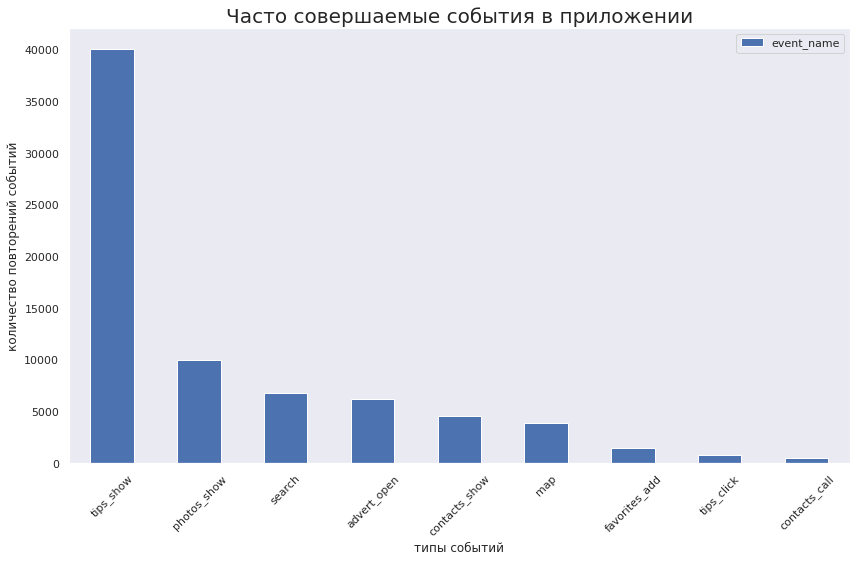

In [56]:
full_events.plot(kind='bar', figsize=(14,8))
plt.title('Часто совершаемые события в приложении', fontsize=20)
plt.gca().set(xlabel='типы событий', ylabel='количество повторений событий')
plt.xticks(rotation=45)
plt;

Количество пользователей совершавших каждое действие

In [57]:
def get_event_count(event_name):
    users_count = df[df['event_name'] == event_name]['user_id'].nunique()
    return users_count

In [58]:
events_count = full_events.reset_index()
events_count['no. of users'] = events_count['index'].apply(get_event_count)
events_count = events_count.sort_values(by='no. of users', ascending=False)
events_count = events_count.set_index('index')
events_count.index.name = None
events_count['percent_of_events'] = events_count['event_name'].apply(lambda x: round(x/full_events['event_name'].sum()*100, 2))
events_count['percent_of_unique_users'] = events_count['no. of users'].apply(lambda x: round(x/df['user_id'].nunique()*100, 2))
events_count

,event_name,no. of users,percent_of_events,percent_of_unique_users
tips_show,40055,2801,53.98,65.25
search,6784,1666,9.14,38.81
map,3881,1456,5.23,33.92
photos_show,10012,1095,13.49,25.51
contacts_show,4529,981,6.10,22.85
advert_open,6164,751,8.31,17.49
favorites_add,1417,351,1.91,8.18
tips_click,814,322,1.10,7.50
contacts_call,541,213,0.73,4.96


Анализ частоты пользовательских действий в приложении выявил следующие закономерности:

Наиболее частое событие — tips_show (рекомендации) — оно охватывает более 65% пользователей и составляет около 54% всех событий. Это говорит о том, что рекомендации, вероятно, отображаются сразу при запуске приложения, автоматически.

Просмотр фотографий (photos_show) — второе по популярности действие. Это может свидетельствовать о высоком интересе к визуальному контенту, что важно учитывать при разработке интерфейса.

Поиск (search) используется сравнительно редко, несмотря на его важность для нахождения конкретных товаров. Только 39% пользователей обращаются к нему. Это может говорить о:

- неудобном расположении элемента поиска,

- или об отсутствии потребности в точном фильтрации — пользователи предпочитают "пролистывать" предложения.

Действия, связанные с карточками объявлений (advert_open, contacts_show, contacts_call) совершаются существенно реже, особенно — звонки. Только около 5% пользователей совершают звонок через приложение. Это может быть связано с предпочтением звонков напрямую, мессенджерами или низкой заинтересованностью в товаре.

### Конверсия в целевое действие — просмотр контактов

Cгруппируем данные по пользователям и номеру сессии и просуммируем время, проведенное в приложении

In [59]:
features = df.groupby('user_id', as_index=False)\
.agg({'active_session':'sum', 'event_date':'count'})\
.rename(columns={'event_date':'visits'})

In [60]:
features.head()

,user_id,active_session,visits
0,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,0 days 00:46:00,35
1,00157779-810c-4498-9e05-a1e9e3cedf93,0 days 03:16:15,71
2,00463033-5717-4bf1-91b4-09183923b9df,0 days 00:24:43,10
3,004690c3-5a84-4bb7-a8af-e0c8f8fca64e,0 days 01:50:44,32
4,00551e79-152e-4441-9cf7-565d7eb04090,0 days 00:09:20,8


посчитаем, сколько раз пользователи совершили целевое действие - просмотр контактов

In [61]:
conversion = df.query('event_name=="contacts_show"')\
.groupby('user_id', as_index=False)\
.agg({'event_name':'count'})\
.rename(columns={'event_name':'conversions'})

In [62]:
conversion

,user_id,conversions
0,00157779-810c-4498-9e05-a1e9e3cedf93,11
1,00551e79-152e-4441-9cf7-565d7eb04090,3
2,005fbea5-2678-406f-88a6-fbe9787e2268,3
3,00753c79-ea81-4456-acd0-a47a23ca2fb9,1
4,007d031d-5018-4e02-b7ee-72a30609173f,2
...,...,...
976,fee3ba1c-16f4-46f7-bf56-4bf80cc4e2f5,17
977,ff1554b5-919e-40b1-90bb-ee1f7f6d5846,1
978,ffc01466-fdb1-4460-ae94-e800f52eb136,1
979,ffe68f10-e48e-470e-be9b-eeb93128ff1a,1


добавим столбец conversions в датасет с признаками

In [63]:
features = pd.merge(features, conversion, on='user_id', how='left')

заменим пропуски нулями

In [64]:
features['conversions'] = features['conversions'].fillna(0)

In [65]:
features.sample(10)

,user_id,active_session,visits,conversions
3188,bfb4a245-978f-4e0d-b3d9-e46275df6dcb,0 days 00:24:50,5,0.00
2130,7f4f6c5b-7ce9-4141-9757-bf5922c5e061,0 days 02:09:10,53,0.00
3448,ce30f4d2-2c14-4317-b7cf-7eee595aac35,0 days 00:45:54,21,0.00
3156,bdd67a79-fbbe-40b0-a8f6-d8fa5a782a39,0 days 02:52:40,105,0.00
1548,5d82386f-d0ab-439c-92b1-d7572102c369,0 days 01:01:37,27,0.00
2036,7a4806d3-b727-43f7-9edc-d5068869d95d,0 days 04:32:47,124,4.00
3167,be849e0d-19af-45d9-9725-e79edf3d8b6f,0 days 00:10:31,6,0.00
2068,7c311438-9726-4487-bc7a-21f23ab31dae,0 days 00:11:11,8,0.00
3252,c2e5c060-fdd6-4b17-880b-c3902733e975,0 days 00:36:11,20,3.00
1593,5f71e670-bb34-45da-a287-96f92eedfd6c,0 days 00:01:13,6,0.00


Построим график количества конверсий в просмотр контакта

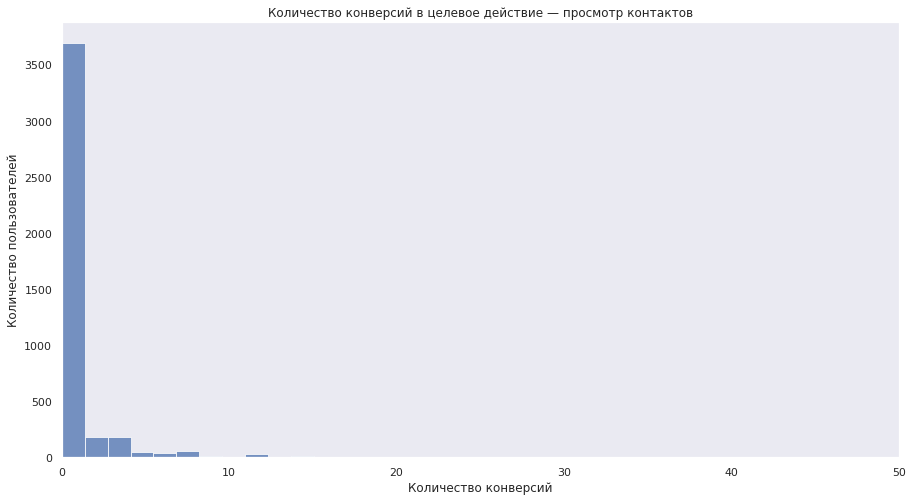

[ 2.  5. 15.]


In [66]:
plt.figure(figsize=(15, 8))
sns.histplot(features['conversions'], bins=100)
plt.title('Количество конверсий в целевое действие — просмотр контактов')
plt.xlabel('Количество конверсий')
plt.ylabel('Количество пользователей')
plt.xlim(0, 50)
plt.show()
print(np.percentile(features['conversions'], [90, 95, 99]))

На каждого пользователя приходится от одной до 5 сессий;
Большая часть пользователей не совершает целевое действие - просмотр контактов.

Чтобы вычислить конверсию в действие contacts_show, отфильтруем основной датафрейм (с помощью метода query) по интересующему нас действию. Затем найдем количество уникальных пользователей в отфильтрованной таблице и разделим количество уникальных пользователей из отфильтрованной таблицы contacts_show_df на количество уникальных пользователей из основной таблицы и умножим на 100

In [67]:
contacts_show_df = df.query('event_name == "contacts_show"')

In [68]:
contacts_show_df['user_id'].nunique()

981

In [69]:
(contacts_show_df['user_id'].nunique() / df['user_id'].nunique()) * 100

22.851153039832283

Конверсия в целевое действие — просмотр контактов — составляет около 23%. Это указывает на то, что значительная часть пользователей не доходит до этого этапа. Возможные причины могут включать:

- Пользователи "теряются" в большом количестве рекомендаций.
- Интерфейс приложения недостаточно интуитивен, что усложняет путь пользователя к целевому действию.

В результате анализа поведения пользователей были получены следующие ключевые наблюдения:

- Удержание пользователей (Retention Rate):

Retention заметно снижается с каждой последующей неделей. Например, когорта пользователей от 7–13 октября показывает удержание на второй неделе около 7%.

Новые когорты демонстрируют всё более низкие показатели вовлеченности, что указывает на ухудшение пользовательского опыта или снижение интереса к приложению.

Динамика retention требует дополнительного анализа — важно выявить факторы, влияющие на отток (например, источник установки, первый опыт пользователя, навигация и пр.).

- Активность в приложении:

В среднем пользователь совершает около 2–2,4 сессий в месяц, а длительность одной сессии составляет около 13 минут.

Это подтверждается медианой и средним количеством сессий, которые практически совпадают, что говорит о стабильном пользовательском паттерне.

Для специфики приложения («Ненужные вещи») это может быть приемлемо: пользователю важно быстро найти интересующее объявление, без долгого пребывания в интерфейсе.

- Частота и структура действий:

Наиболее часто фиксируемое действие — tips_show, что говорит о частом взаимодействии с рекомендательным блоком. Однако оно не отражает активную вовлеченность, поскольку происходит автоматически.

Пользователи чаще просматривают фотографии (photos_show), чем используют поиск (search). Это может указывать на неинтуитивное расположение поисковой функции или предпочтение визуального контента.

Целевое действие — contacts_show — совершается лишь 23% пользователей. Это сигнализирует о значительном «провале» в воронке: пользователи не доходят до контактов даже после просмотра объявлений.

- Вывод по вовлеченности:

Общий паттерн показывает: пользователи быстро взаимодействуют с контентом, но редко совершают ключевые действия.

Возможные причины: перегруженность рекомендациями, неудобная навигация, отсутствие триггеров к действию или неинтуитивный интерфейс.

## Сегментация пользователей по действиям

Маркировка признаков

В этой функции мы маркируем пользователей, которые совершали определенные действия. При группировке по пользователю можно как сложить единицы, чтобы узнать, сколько раз пользователь совершал данное действие (сколько раз посмотрел контакты), так и просто увидеть, совершалось ли вообще пользователем это действие (посмотрел ли контакты хоть раз)."

In [70]:
def add_sign(name):

    df[name] = ""
    for i in range(len(df['event_name'])):
        if df['event_name'][i] == name:
            df[name][i] = 1
        else:
            df[name][i] = 0

In [71]:
add_sign('contacts_show')

In [72]:
add_sign('photos_show')

In [73]:
add_sign('tips_show')

In [74]:
add_sign('search')

In [75]:
df.sample(10)

,event_time,event_name,user_id,source,event_hour,event_week,event_month,event_year,event_date,start_dt,activ_week,start_week,cohort_lifetime,pre_action_time,active_session,session_num,contacts_show,photos_show,tips_show,search
28908,2019-10-15 09:31:30,tips_show,e5c3b198-6021-4ccb-8cf3-2bc61197118b,yandex,9,2019-10-10,2019-10-01,2019-01-01,2019-10-15,2019-10-15,2019-10-14,2019-10-14,0,2019-10-15 09:30:33,0 days 00:00:57,1,0,0,1,0
51327,2019-10-23 12:33:44,tips_show,cae4c469-26c9-4677-9889-95c35c74571a,yandex,12,2019-10-17,2019-10-01,2019-01-01,2019-10-23,2019-10-23,2019-10-21,2019-10-21,0,2019-10-23 12:32:07,0 days 00:01:37,1,0,0,1,0
57850,2019-11-01 18:49:33,map,395bdd53-9193-452f-8b7c-bd4eebd15707,google,18,2019-10-31,2019-11-01,2019-01-01,2019-11-01,2019-10-25,2019-10-28,2019-10-21,1,2019-10-26 10:51:57,0,3,0,0,0,0
43199,2019-10-19 23:05:24,tips_show,99f49db7-3073-428e-a3fe-db4040eadde5,google,23,2019-10-17,2019-10-01,2019-01-01,2019-10-19,2019-10-19,2019-10-14,2019-10-14,0,2019-10-19 23:04:08,0 days 00:01:16,1,0,0,1,0
53168,2019-10-27 14:07:13,tips_show,eb1fd737-8bf3-434a-a31b-ea7747e35e04,yandex,14,2019-10-24,2019-10-01,2019-01-01,2019-10-27,2019-10-23,2019-10-21,2019-10-21,0,2019-10-27 14:04:59,0 days 00:02:14,2,0,0,1,0
20830,2019-10-12 20:28:34,tips_show,c140f88a-c544-4ce6-a6bd-578a1a0d1b18,yandex,20,2019-10-10,2019-10-01,2019-01-01,2019-10-12,2019-10-12,2019-10-07,2019-10-07,0,2019-10-12 20:27:07,0 days 00:01:27,1,0,0,1,0
68768,2019-10-30 21:56:08,tips_show,f6fc8cc6-7340-4be1-bb42-49ffa70ae230,yandex,21,2019-10-24,2019-10-01,2019-01-01,2019-10-30,2019-10-30,2019-10-28,2019-10-28,0,2019-10-30 21:49:02,0 days 00:07:06,1,0,0,1,0
50904,2019-10-28 10:44:46,tips_show,b76914c3-031d-43f6-95e7-aec7750a0bee,other,10,2019-10-24,2019-10-01,2019-01-01,2019-10-28,2019-10-23,2019-10-28,2019-10-21,1,2019-10-28 10:40:17,0 days 00:04:29,9,0,0,1,0
32537,2019-10-16 14:19:38,contacts_show,320cab3c-e823-4dff-8c01-c4253764640a,google,14,2019-10-10,2019-10-01,2019-01-01,2019-10-16,2019-10-16,2019-10-14,2019-10-14,0,2019-10-16 14:19:10,0 days 00:00:28,2,1,0,0,0
53052,2019-10-23 20:02:38,contacts_show,ea432c4c-1db9-44d7-91e4-2d470202d9f1,google,20,2019-10-17,2019-10-01,2019-01-01,2019-10-23,2019-10-23,2019-10-21,2019-10-21,0,2019-10-23 20:01:59,0 days 00:00:39,1,1,0,0,0


Добавим дату крайнего действия пользователя

In [76]:
last_visits = df.groupby(['user_id'])['event_date'].max().reset_index()
last_visits.columns = ['user_id', 'last_dt']

In [77]:
df = df.merge(last_visits, on='user_id')

In [78]:
df['duration'] = (df['last_dt'] - df['start_dt']).dt.days + 1

In [79]:
grouped_by_user = df.groupby('user_id').agg({'duration':'mean', 
                                                          'session_num':'count', 
                                                          'event_name':'count',
                                                          'contacts_show':'sum', 
                                                          'photos_show':'max',
                                                          'tips_show':'max',
                                                          'search':'max'})
grouped_by_user = grouped_by_user.rename(columns={'session_num':'n_session', 'event_name':'n_event', 'contacts_show':'n_contacts_show'})
grouped_by_user

,duration,n_session,n_event,n_contacts_show,photos_show,tips_show,search
user_id,,,,,,,
0001b1d5-b74a-4cbf-aeb0-7df5947bf349,16,35,35,0,0,1,0
00157779-810c-4498-9e05-a1e9e3cedf93,16,71,71,11,1,0,1
00463033-5717-4bf1-91b4-09183923b9df,1,10,10,0,1,0,0
004690c3-5a84-4bb7-a8af-e0c8f8fca64e,14,32,32,0,0,1,1
00551e79-152e-4441-9cf7-565d7eb04090,5,8,8,3,1,0,1
...,...,...,...,...,...,...,...
ffab8d8a-30bb-424a-a3ab-0b63ebbf7b07,14,17,17,0,0,1,0
ffc01466-fdb1-4460-ae94-e800f52eb136,1,7,7,1,1,0,0
ffcf50d9-293c-4254-8243-4890b030b238,1,2,2,0,0,1,0


In [80]:
# Проверяем, что n_session не равно нулю, чтобы избежать деления на ноль
grouped_by_user['conversion'] = grouped_by_user.apply(
    lambda row: row['n_contacts_show'] / row['n_session'] if row['n_session'] != 0 else 0, axis=1
)

grouped_by_user

,duration,n_session,n_event,n_contacts_show,photos_show,tips_show,search,conversion
user_id,,,,,,,,
0001b1d5-b74a-4cbf-aeb0-7df5947bf349,16,35,35,0,0,1,0,0.00
00157779-810c-4498-9e05-a1e9e3cedf93,16,71,71,11,1,0,1,0.15
00463033-5717-4bf1-91b4-09183923b9df,1,10,10,0,1,0,0,0.00
004690c3-5a84-4bb7-a8af-e0c8f8fca64e,14,32,32,0,0,1,1,0.00
00551e79-152e-4441-9cf7-565d7eb04090,5,8,8,3,1,0,1,0.38
...,...,...,...,...,...,...,...,...
ffab8d8a-30bb-424a-a3ab-0b63ebbf7b07,14,17,17,0,0,1,0,0.00
ffc01466-fdb1-4460-ae94-e800f52eb136,1,7,7,1,1,0,0,0.14
ffcf50d9-293c-4254-8243-4890b030b238,1,2,2,0,0,1,0,0.00


In [81]:
grouped_by_user.describe()

,duration,n_session,n_event,n_contacts_show,photos_show,tips_show,search,conversion
count,"4,293.00","4,293.00","4,293.00","4,293.00","4,293.00","4,293.00","4,293.00","4,293.00"
mean,3.61,17.28,17.28,1.05,0.26,0.65,0.39,0.06
std,5.19,29.13,29.13,4.99,0.44,0.48,0.49,0.15
min,1.00,1.00,1.00,0.00,0.00,0.00,0.00,0.00
25%,1.00,5.00,5.00,0.00,0.00,0.00,0.00,0.00
50%,1.00,9.00,9.00,0.00,0.00,1.00,0.00,0.00
75%,4.00,17.00,17.00,0.00,1.00,1.00,1.00,0.00
max,28.00,478.00,478.00,137.00,1.00,1.00,1.00,1.00


Поделим пользователей на 4 группы в зависимости от их активности и достижения цели:

Часто пользуются и смотрят контакты.
Активно пользуется приложением, но ни разу не смотрели контакты.
Пользовался и смотрел контакты, но давно (так как у нас данные только за месяц, возьмем 3 недели).
Почти не пользуется, контакты не смотрел ни разу.

In [82]:
# Проверяем, что значения в столбцах duration и n_contacts_show корректны
valid_data = grouped_by_user[
    (grouped_by_user['duration'] >= 0) &
    (grouped_by_user['n_contacts_show'] >= 0)
]

In [83]:
active_contacts_show = grouped_by_user.query('duration >= 2 and n_contacts_show >= 1')
active_no_contacts_show = grouped_by_user.query('duration >= 2 and n_contacts_show == 0')
inactive_contacts_show = grouped_by_user.query('duration < 2 and n_contacts_show >= 1')
inactive_no_contacts_show = grouped_by_user.query('duration < 2 and n_contacts_show == 0')

In [84]:
active_contacts_show.describe()

,duration,n_session,n_event,n_contacts_show,photos_show,tips_show,search,conversion
count,528.00,528.00,528.00,528.00,528.00,528.00,528.00,528.00
mean,8.26,40.67,40.67,5.85,0.42,0.49,0.48,0.20
std,6.49,60.78,60.78,12.06,0.49,0.50,0.50,0.19
min,2.00,2.00,2.00,1.00,0.00,0.00,0.00,0.00
25%,3.00,10.00,10.00,1.00,0.00,0.00,0.00,0.06
50%,6.00,20.00,20.00,2.00,0.00,0.00,0.00,0.14
75%,12.00,43.25,43.25,6.00,1.00,1.00,1.00,0.28
max,28.00,478.00,478.00,137.00,1.00,1.00,1.00,1.00


Активные, достигают цели - работаем над другими группами, чтобы увеличить численность этой.

In [85]:
active_no_contacts_show.describe()

,duration,n_session,n_event,n_contacts_show,photos_show,tips_show,search,conversion
count,"1,009.00","1,009.00","1,009.00","1,009.00","1,009.00","1,009.00","1,009.00","1,009.00"
mean,8.32,23.11,23.11,0.00,0.32,0.63,0.47,0.00
std,6.36,30.57,30.57,0.00,0.47,0.48,0.50,0.00
min,2.00,2.00,2.00,0.00,0.00,0.00,0.00,0.00
25%,3.00,7.00,7.00,0.00,0.00,0.00,0.00,0.00
50%,6.00,13.00,13.00,0.00,0.00,1.00,0.00,0.00
75%,12.00,26.00,26.00,0.00,1.00,1.00,1.00,0.00
max,28.00,407.00,407.00,0.00,1.00,1.00,1.00,0.00


Эта группа вторая по численности: активны, но не интересуются контактами. Возможно они "осматриваются" или не могут найти то, что им нужно. Нужно детальнее посмотреть, как они пользуются приложением: может им недостаточно финкционала приложения (нет возможности уточнения запроса, фильтров).

In [86]:
inactive_contacts_show.describe()

,duration,n_session,n_event,n_contacts_show,photos_show,tips_show,search,conversion
count,453.00,453.00,453.00,453.00,453.00,453.00,453.00,453.00
mean,1.00,12.64,12.64,3.18,0.25,0.56,0.27,0.31
std,0.00,13.04,13.04,5.21,0.44,0.50,0.45,0.26
min,1.00,1.00,1.00,1.00,0.00,0.00,0.00,0.01
25%,1.00,5.00,5.00,1.00,0.00,0.00,0.00,0.12
50%,1.00,8.00,8.00,2.00,0.00,1.00,0.00,0.23
75%,1.00,15.00,15.00,3.00,1.00,1.00,1.00,0.40
max,1.00,104.00,104.00,65.00,1.00,1.00,1.00,1.00


Самая маленькая группа пользователей. Они пользовались приложением лишь раз, но все равно достигли цели.

In [87]:
inactive_no_contacts_show.describe()

,duration,n_session,n_event,n_contacts_show,photos_show,tips_show,search,conversion
count,"2,303.00","2,303.00","2,303.00","2,303.00","2,303.00","2,303.00","2,303.00","2,303.00"
mean,1.00,10.28,10.28,0.00,0.19,0.72,0.35,0.00
std,0.00,10.01,10.01,0.00,0.39,0.45,0.48,0.00
min,1.00,1.00,1.00,0.00,0.00,0.00,0.00,0.00
25%,1.00,5.00,5.00,0.00,0.00,0.00,0.00,0.00
50%,1.00,7.00,7.00,0.00,0.00,1.00,0.00,0.00
75%,1.00,12.00,12.00,0.00,0.00,1.00,1.00,0.00
max,1.00,97.00,97.00,0.00,1.00,1.00,1.00,0.00


Самая многочисленная группа - почти не пользуются и не достигают цели. Необходимо искать способ "вернуть" их в прилжение.

Вывод

Пользователи были разделены на четыре группы в зависимости от их активности и достижения целевого действия:

Активные пользователи, достигающие цели: Эта группа активно использует приложение и регулярно просматривает контакты. Основные усилия должны быть направлены на поддержание и увеличение численности этой группы.

Активные пользователи, не достигающие цели: Пользователи в этой группе активно используют приложение, но не проявляют интереса к просмотру контактов. Возможно, им не хватает функционала или они не могут найти то, что им нужно. Необходимо детальнее изучить их поведение в приложении.

Малопользующиеся, но достигающие цели: Эта группа пользователей использовала приложение лишь раз, но достигла цели. Возможно, стоит напомнить им о приложении с помощью уведомлений или других методов вовлечения.

Малопользующиеся и не достигающие цели: Самая многочисленная группа, которая почти не использует приложение и не достигает цели. Необходимо разработать стратегии для возвращения этих пользователей в приложение, такие как пуш-уведомления и рассылки.


У нас также не пересекаются пользователи, которые пользуются рекомендованными объявлениями, и те, кто ищет через строку поиска. Мы можем разделить пользователей по тому, что они выбрали поиск или рекомендации и придумать способы поднятия конверсии в каждой группе:

In [88]:
tips_show_yes = grouped_by_user.query('tips_show == 1')
search_yes = grouped_by_user.query('search == 1')

Text(0.5, 0, 'Конверсии в просмотры')

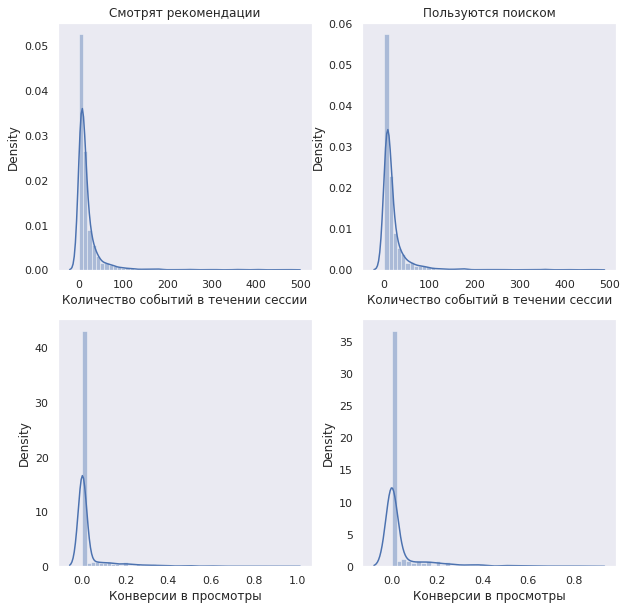

In [89]:
fig = plt.figure(figsize=(10,10))
area = fig.add_subplot(2, 2, 1)
ax = sns.distplot(tips_show_yes['n_event'])
ax.set_title("Смотрят рекомендации")
ax.set_xlabel("Количество событий в течении сессии")

area = fig.add_subplot(2, 2, 2)
ax = sns.distplot(search_yes['n_event'])
ax.set_title("Пользуются поиском")
ax.set_xlabel("Количество событий в течении сессии")

area = fig.add_subplot(2, 2, 3)
ax = sns.distplot(tips_show_yes['conversion'])
ax.set_xlabel("Конверсии в просмотры")


area = fig.add_subplot(2, 2, 4)
ax=sns.distplot(search_yes['conversion'])
ax.set_xlabel("Конверсии в просмотры")

Пользователи всё чаще обращаются к рекомендациям, но эффективность их использования оставляет желать лучшего. Они просто просматривают предложения, не делая выбор.

Необходимо проанализировать работу системы подбора рекомендуемых объявлений и определить, какие улучшения можно внести. После этого следует провести тестирование изменений.

Также можно усовершенствовать процесс поиска, повысив релевантность выдачи, добавив фильтры и другие функции.

Добавим информацию об источниках и разобьем пользователей на группы

In [90]:
grouped_by_user = grouped_by_user.merge(sources, on='user_id')
grouped_by_user

,user_id,duration,n_session,n_event,n_contacts_show,photos_show,tips_show,search,conversion,source
0,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,16,35,35,0,0,1,0,0.00,other
1,00157779-810c-4498-9e05-a1e9e3cedf93,16,71,71,11,1,0,1,0.15,yandex
2,00463033-5717-4bf1-91b4-09183923b9df,1,10,10,0,1,0,0,0.00,yandex
3,004690c3-5a84-4bb7-a8af-e0c8f8fca64e,14,32,32,0,0,1,1,0.00,google
4,00551e79-152e-4441-9cf7-565d7eb04090,5,8,8,3,1,0,1,0.38,yandex
...,...,...,...,...,...,...,...,...,...,...
4288,ffab8d8a-30bb-424a-a3ab-0b63ebbf7b07,14,17,17,0,0,1,0,0.00,yandex
4289,ffc01466-fdb1-4460-ae94-e800f52eb136,1,7,7,1,1,0,0,0.14,yandex
4290,ffcf50d9-293c-4254-8243-4890b030b238,1,2,2,0,0,1,0,0.00,google
4291,ffe68f10-e48e-470e-be9b-eeb93128ff1a,8,13,13,1,1,0,1,0.08,yandex


In [91]:
grouped_by_user.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4293 entries, 0 to 4292
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   user_id          4293 non-null   object 
 1   duration         4293 non-null   int64  
 2   n_session        4293 non-null   int64  
 3   n_event          4293 non-null   int64  
 4   n_contacts_show  4293 non-null   int64  
 5   photos_show      4293 non-null   int64  
 6   tips_show        4293 non-null   int64  
 7   search           4293 non-null   int64  
 8   conversion       4293 non-null   float64
 9   source           4293 non-null   object 
dtypes: float64(1), int64(7), object(2)
memory usage: 368.9+ KB


Разделим пользователей на группы по источнику и визуально их сравним:

In [92]:
source_yandex = grouped_by_user.query('source == "yandex"')
source_google = grouped_by_user.query('source == "google"')

In [93]:
source_yandex.describe()

,duration,n_session,n_event,n_contacts_show,photos_show,tips_show,search,conversion
count,"1,934.00","1,934.00","1,934.00","1,934.00","1,934.00","1,934.00","1,934.00","1,934.00"
mean,3.58,17.73,17.73,1.05,0.23,0.68,0.32,0.06
std,5.09,30.83,30.83,4.36,0.42,0.47,0.47,0.16
min,1.00,1.00,1.00,0.00,0.00,0.00,0.00,0.00
25%,1.00,5.00,5.00,0.00,0.00,0.00,0.00,0.00
50%,1.00,9.00,9.00,0.00,0.00,1.00,0.00,0.00
75%,4.00,18.00,18.00,0.00,0.00,1.00,1.00,0.00
max,28.00,478.00,478.00,86.00,1.00,1.00,1.00,1.00


In [94]:
source_google.describe()

,duration,n_session,n_event,n_contacts_show,photos_show,tips_show,search,conversion
count,"1,129.00","1,129.00","1,129.00","1,129.00","1,129.00","1,129.00","1,129.00","1,129.00"
mean,3.48,18.11,18.11,1.28,0.32,0.58,0.43,0.06
std,5.11,32.09,32.09,6.58,0.47,0.49,0.50,0.16
min,1.00,1.00,1.00,0.00,0.00,0.00,0.00,0.00
25%,1.00,5.00,5.00,0.00,0.00,0.00,0.00,0.00
50%,1.00,9.00,9.00,0.00,0.00,1.00,0.00,0.00
75%,3.00,18.00,18.00,0.00,1.00,1.00,1.00,0.00
max,28.00,397.00,397.00,137.00,1.00,1.00,1.00,1.00


Text(0.5, 0, 'Конверсии в просмотры')

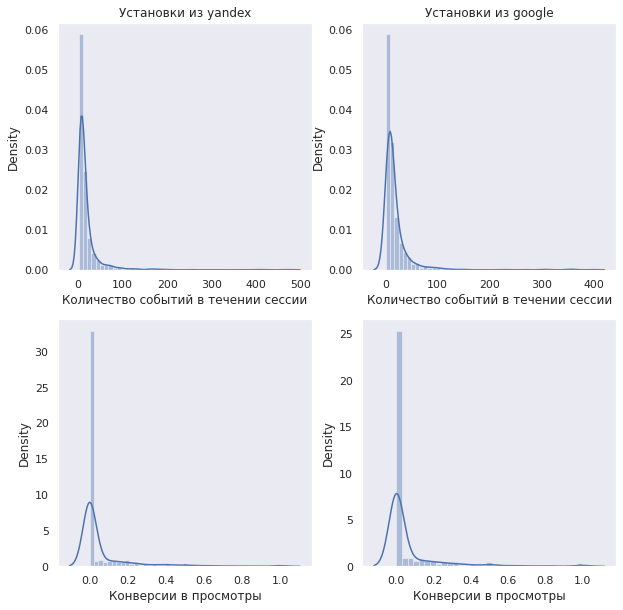

In [95]:
fig = plt.figure(figsize=(10,10))
area = fig.add_subplot(2, 2, 1)
ax = sns.distplot(source_yandex['n_event'])
ax.set_title("Установки из yandex")
ax.set_xlabel("Количество событий в течении сессии")

area = fig.add_subplot(2, 2, 2)
ax = sns.distplot(source_google['n_event'])
ax.set_title("Установки из google")
ax.set_xlabel("Количество событий в течении сессии")

area = fig.add_subplot(2, 2, 3)
ax = sns.distplot(source_yandex['conversion'])
ax.set_xlabel("Конверсии в просмотры")


area = fig.add_subplot(2, 2, 4)
ax=sns.distplot(source_google['conversion'])
ax.set_xlabel("Конверсии в просмотры")

При рассмотрении по источникам установки видно, пользователи установившие приложение из Googla просматривают контакт более активно

## Проверка статистических гипотез

### Некоторые пользователи установили приложение по ссылке из yandex , другие — из google . Проверим гипотезу: две эти группы демонстрируют разную конверсию в просмотры контактов

Разделим данные на группы в зависимости от источника установки приложения:

In [96]:
google_df = df.query('source == "google"')
yandex_df = df.query('source == "yandex"')

Для проверки гипотезы мы проведем z-test. С помощью метода pivot_table создадим таблицу users_events_per_group, в которой по действиям и источникам посчитаем уникальных пользователей:

H0 - "Конверсии групп Google и Яндекс в просмотр контактов равны".

H1 - "Конверсии групп Google и Яндекс в просмотр контактов различаются".

Trial

In [97]:
trials_yandex = yandex_df.user_id.nunique()
trials_google = google_df.user_id.nunique()

Succes

In [98]:
successes_yandex = yandex_df.query('event_name=="contacts_show" & source == "yandex"').user_id.nunique()
successes_google = google_df.query('event_name=="contacts_show"').user_id.nunique()

In [99]:
conversion_yandex = successes_yandex / trials_yandex

In [100]:
conversion_google = successes_google / trials_google

In [101]:
alpha = .05 # критический уровень статистической значимости


        
successes = np.array([successes_google, successes_yandex])
trials = np.array([trials_google, trials_yandex]) 
        
print("successes: ")
print(successes)

print("trials:")
print(trials)

# пропорция успехов в первой группе:
p1 = successes[0]/trials[0]

# пропорция успехов во второй группе:
p2 = successes[1]/trials[1]

# пропорция успехов в комбинированном датасете:
p_combined = (successes[0] + successes[1]) / (trials[0] + trials[1])

# разница пропорций в датасетах
difference = p1 - p2 

# считаем статистику в ст.отклонениях стандартного нормального распределения
z_value = difference / mth.sqrt(p_combined * (1 - p_combined) * (1/trials[0] + 1/trials[1]))

# задаем стандартное нормальное распределение (среднее 0, ст.отклонение 1)
distr = st.norm(0, 1)  

# считаем статистику в ст.отклонениях стандартного нормального распределения
z_value = difference / mth.sqrt(p_combined * (1 - p_combined) * (1/trials[0] + 1/trials[1]))

# задаем стандартное нормальное распределение (среднее 0, ст.отклонение 1)
distr = st.norm(0, 1) 

p_value = (1 - distr.cdf(abs(z_value))) * 2
print(f'p_values = {p_value}')
if (p_value < alpha):
    print("Отвергаем нулевую гипотезу: разница статистически значима")
else:
    print("Не получилось отвергнуть нулевую гипотезу, статистически значимых отличий нет") 
print(f'Средняя конверсия в просмотры контактов у пользователей, которые совершили установку приложения, прийдя с источника yandex: {conversion_yandex:.2%}')
print(f'Средняя конверсия в просмотры контактов у пользователей, которые совершили установку приложения, прийдя с источника google: {conversion_google:.2%}')

successes: 
[275 478]
trials:
[1129 1934]
p_values = 0.8244316027993777
Не получилось отвергнуть нулевую гипотезу, статистически значимых отличий нет
Средняя конверсия в просмотры контактов у пользователей, которые совершили установку приложения, прийдя с источника yandex: 24.72%
Средняя конверсия в просмотры контактов у пользователей, которые совершили установку приложения, прийдя с источника google: 24.36%


Вывод: Поскольку p-значение (0.8244) больше уровня значимости (0.05), мы не можем отвергнуть нулевую гипотезу. Это означает, что нет статистически значимых различий в конверсии в просмотры контактов между пользователями, установившими приложение из Yandex и Google.

### Время, проведенное в приложении, отличается в зависимости от источника установки приложения (google, yandex)

Нулевая гипотеза (H0): Время, проведенное в приложении, не отличается в зависимости от источника установки приложения (Google или Yandex).


Альтернативная гипотеза (H1): Время, проведенное в приложении, отличается в зависимости от источника установки приложения (Google или Yandex).

In [102]:

# Для проверки гипотезы мы проведем z-test.

# Преобразуем столбец 'active_session' в секунды
df['active_session_seconds'] = pd.to_timedelta(df['active_session']).dt.total_seconds()

# Разделение данных по источникам установки приложения
google_df = df[df['source'] == 'google']
yandex_df = df[df['source'] == 'yandex']

# Trials
trials_yandex = yandex_df['user_id'].nunique()
trials_google = google_df['user_id'].nunique()

# Successes
successes_yandex = yandex_df['active_session_seconds'].sum()
successes_google = google_df['active_session_seconds'].sum()

# Среднее время, проведенное в приложении
mean_time_yandex = successes_yandex / trials_yandex
mean_time_google = successes_google / trials_google

alpha = 0.05  # критический уровень статистической значимости

successes = np.array([successes_google, successes_yandex])
trials = np.array([trials_google, trials_yandex])

print("successes: ")
print(successes)

print("trials:")
print(trials)

# Среднее время в первой группе:
p1 = successes[0] / trials[0]

# Среднее время во второй группе:
p2 = successes[1] / trials[1]

# Среднее время в комбинированном датасете:
p_combined = (successes[0] + successes[1]) / (trials[0] + trials[1])

# Разница средних значений в датасетах
difference = p1 - p2

# Рассчитываем статистику в стандартных отклонениях стандартного нормального распределения
z_value = difference / st.sem(yandex_df['active_session_seconds'].append(google_df['active_session_seconds']))

# Задаем стандартное нормальное распределение (среднее 0, стандартное отклонение 1)
distr = st.norm(0, 1)

p_value = (1 - distr.cdf(abs(z_value))) * 2
print(f'z_value = {z_value}')
print(f'p_value = {p_value}')

if p_value < alpha:
    print("Отвергаем нулевую гипотезу: разница статистически значима")
else:
    print("Не получилось отвергнуть нулевую гипотезу, статистически значимых отличий нет")

print(f'Среднее время, проведенное в приложении, для пользователей, установивших приложение из Google: {mean_time_google:.2f} секунд')
print(f'Среднее время, проведенное в приложении, для пользователей, установивших приложение из Yandex: {mean_time_yandex:.2f} секунд')

successes: 
[2224161. 3816364.]
trials:
[1129 1934]
z_value = -3.8422054610437186
p_value = 0.00012193369637536478
Отвергаем нулевую гипотезу: разница статистически значима
Среднее время, проведенное в приложении, для пользователей, установивших приложение из Google: 1970.03 секунд
Среднее время, проведенное в приложении, для пользователей, установивших приложение из Yandex: 1973.30 секунд


На основе результатов z-теста, где p-значение оказалось меньше уровня значимости (0.05), мы отвергаем нулевую гипотезу. Это позволяет сделать вывод, что время, проведенное в приложении, действительно отличается в зависимости от источника установки приложения (Google или Yandex).

Таким образом, можно утверждать, что пользователи, установившие приложение из Google, проводят в среднем 1970.03 секунд, в то время как пользователи, установившие приложение из Yandex, проводят в среднем 1973.30 секунд. Это различие статистически значимо.

## Основные выводы

**Исхлдные данные**

Датасет `mobile_dataset.csv`:

- Содержит **74 197** записей и **3** столбца: `event.time`, `event.name`, и `user.id`.
- Все столбцы имеют тип данных `object`.
- В данных отсутствуют пропущенные значения.

Датасет `mobile_sources.csv`:

- Содержит **4 293** записи и **2** столбца: `userId` и `source`.
- Все столбцы имеют тип данных `object`.
- В данных отсутствуют пропущенные значения.


**Предобработка данных**

Изменение названий столбцов:

- В датасете `data` столбцы были переименованы в `event_time`, `event_name`, и `user_id`.
- В датасете `sources` столбцы были переименованы в `user_id` и `source`.

Преобразование типов данных:

- Столбец `event_time` в датасете `data` был преобразован в формат даты и округлён до **1 секунды**.

Объединение таблиц:

- Количество уникальных пользователей в обоих датасетах совпадает, что позволило объединить их в один датасет `df`.

Добавление дополнительных столбцов:

- Были добавлены столбцы `event_hour`, `event_week`, `event_month`, `event_year`, и `event_date` для более удобного анализа временных данных.

Объединение схожих событий:

- События `contacts_show` и `show_contacts` были объединены в одно событие `contacts_show`.
- События, связанные с поиском (`search_1` до `search_7`), были объединены в одно событие `search`.

Исследование выбросов:

- Было обнаружено, что событие `tips_show` является автоматическим и не зависит от действий пользователей. Однако, его удаление привело бы к значительным потерям данных, поэтому оно было оставлено.

**Удержание пользователей (Retention Rate)**
- Пользователи возвращаются в приложение преимущественно в первую неделю после установки.
- Уже ко второй неделе уровень удержания падает ниже 10%.
- Более поздние когорты демонстрируют всё более низкое удержание.
- **Вывод:** Приложение теряет большую часть новых пользователей в течение первой недели. Это может быть связано с недостаточным вовлечением или непродуманным пользовательским опытом.
- **Рекомендация:** Изучить поведение пользователей в первые дни, определить ключевые точки оттока и оптимизировать onboarding-процесс.


**Время в приложении и сессии**
- Пользователь в среднем проводит **около 13 минут за сессию**.
- В месяц совершается **примерно 2 сессии на пользователя**.
- Общее время использования — **30–40 минут в месяц**.
- **Вывод:** Пользователи используют приложение для кратковременного поиска нужной информации.
- **Рекомендация:** Сосредоточиться на улучшении эффективности и скорости взаимодействия, а не на увеличении времени удержания.


**Частота действий**
- Самое частое событие — `tips_show` (рекомендации), на него приходится более **65% пользователей** и около **54% всех действий**.
- Популярны `photos_show` и `search`, но поиск используют лишь **39% пользователей**, что может указывать на его неудобство или непривлекательность.
- **Вывод:** Рекомендации и визуальный контент — ключевые элементы вовлечения. Поиск и карточки объявлений используются реже.
- **Рекомендация:** Улучшить доступность и функциональность поиска, усилить визуальные элементы и качество рекомендаций.


**Конверсия в целевое действие — `contacts_show`**
- Целевое действие (просмотр контактов) совершают **около 23%** пользователей.
- Только 5% пользователей переходят к звонку.
- **Вывод:** Большинство пользователей не доходят до контакта с продавцом. Возможные причины — сложный путь, неактуальные товары или слабое вовлечение.
- **Рекомендация:** Упростить путь к целевому действию, улучшить релевантность рекомендаций, внедрить A/B тестирование вариантов интерфейса.


**Сегментация пользователей:**
   - Пользователи были разделены на 4 группы в зависимости от их активности и достижения цели(просмотр контактов). Самая многочисленная группа — это пользователи, которые почти не пользуются приложением и не достигают цели. Это указывает на необходимость работы над вовлечением этих пользователей.

**Проверка гипотез:**
   - Гипотеза о различии конверсии в просмотры контактов между пользователями, установившими приложение из Google и Yandex, не подтвердилась.
   - Гипотеза о различии времени, проведенного в приложении, в зависимости от источника установки приложения, была подтверждена.

**Общая рекомендация**
Приложение нуждается в оптимизации первых шагов пользователя и улучшении логики взаимодействия с контентом. Основное внимание стоит уделить:
- **Улучшение системы рекомендаций** для повышения конверсии.
- **Оптимизация интерфейса** для упрощения пути пользователя к целевому действию.
- **Работа над вовлечением пользователей**, которые почти не пользуются приложением, с помощью пуш-уведомлений и рассылок.
- **Улучшение функционала поиска** и добавление фильтров для повышения релевантности выдачи.